# 🪴 01_resize.ipynb  
### Redimensionamiento de imágenes del dataset de hojas de papa

Este notebook redimensiona todas las imágenes del dataset a un tamaño uniforme (por defecto **224×224 px**)  
y las guarda en la carpeta `data/2_data_resize/`, **manteniendo la estructura de clases original**.

Esto garantiza que las imágenes sean consistentes para la posterior extracción de características  
(color, textura, morfología o redes neuronales).


In [11]:
import os
import cv2
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import random
import numpy as np
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops


In [12]:
input_dir = Path("../data/1_data_original")          # Carpeta original con el dataset
output_dir = Path("../data/2_data_resize") # Carpeta destino para las imágenes redimensionadas

target_size = (224, 224)  # tamaño final (ancho, alto)
valid_exts = (".jpg", ".jpeg", ".png", ".bmp")

# Crear la carpeta de salida si no existe
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Carpeta origen: {input_dir}")
print(f"Carpeta destino: {output_dir}")
print(f"Tamaño objetivo: {target_size}")

Carpeta origen: ..\data\1_data_original
Carpeta destino: ..\data\2_data_resize
Tamaño objetivo: (224, 224)


In [13]:
# === Rangos para segmentación y re-mascarado ===
lower_dark_green  = np.array([20, 40, 20])
upper_dark_green  = np.array([80, 255, 255])

lower_light_green = np.array([30, 10, 40])
upper_light_green = np.array([90, 255, 255])

lower_yellow      = np.array([14, 30, 80])
upper_yellow      = np.array([35, 255, 255])


# Segmentación
def segment_leaf(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_dark_green, upper_dark_green) | \
           cv2.inRange(hsv, lower_light_green, upper_light_green) | \
           cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((7,7), np.uint8))
    mask = cv2.medianBlur(mask, 7)
    result = cv2.bitwise_and(image, image, mask=mask)
    return result, mask

# CLAHE en L
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

# Bordes (Canny)
def extract_edges(gray):
    return cv2.Canny(gray, 50, 150)

# Venación (Top-hat)
def extract_veins(gray):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    return cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)

# Textura (LBP + GLCM)
def extract_texture(gray):
    # LBP
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), density=True)
    
    # GLCM
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0,0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0,0]
    
    return lbp_hist, contrast, homogeneity


In [14]:
for class_folder in sorted(os.listdir(input_dir)):
    class_path = input_dir / class_folder
    if not class_path.is_dir():
        continue
    (output_dir / class_folder).mkdir(parents=True, exist_ok=True)

    for img_file in tqdm(os.listdir(class_path), desc=f"Procesando {class_folder}"):
        if not img_file.lower().endswith(valid_exts):
            continue
        
        img_path = class_path / img_file
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"No se pudo leer {img_path}")
            continue
        
        # 1) Redimensionar
        resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        
        # 2) Segmentación
        segmented, mask = segment_leaf(resized)
        
        # 3) CLAHE
        clahe_img = apply_clahe(segmented)
        
        # 4) Máscara final
        hsv2 = cv2.cvtColor(clahe_img, cv2.COLOR_BGR2HSV)
        mask_final = cv2.inRange(hsv2, lower_dark_green, upper_dark_green) | \
                     cv2.inRange(hsv2, lower_light_green, upper_light_green) | \
                     cv2.inRange(hsv2, lower_yellow, upper_yellow)
        final_img = cv2.bitwise_and(clahe_img, clahe_img, mask=mask_final)
        
        # 5) Convertir a gris para bordes y venas
        gray = cv2.cvtColor(final_img, cv2.COLOR_BGR2GRAY)
        edges = extract_edges(gray)
        veins = extract_veins(gray)
        lbp_hist, contrast, homogeneity = extract_texture(gray)
        
        # 6) Guardar resultados
        save_folder = output_dir / class_folder
        cv2.imwrite(str(save_folder / f"{img_file}_segmented.png"), final_img)
        cv2.imwrite(str(save_folder / f"{img_file}_edges.png"), edges)
        cv2.imwrite(str(save_folder / f"{img_file}_veins.png"), veins)


Procesando Virus: 100%|██████████| 532/532 [00:19<00:00, 27.92it/s]


### 🔍 Verificación visual de resultados

Seleccionaremos una imagen al azar para comparar **antes y después del redimensionamiento**.
Esto permite confirmar que no se haya perdido información relevante visualmente.


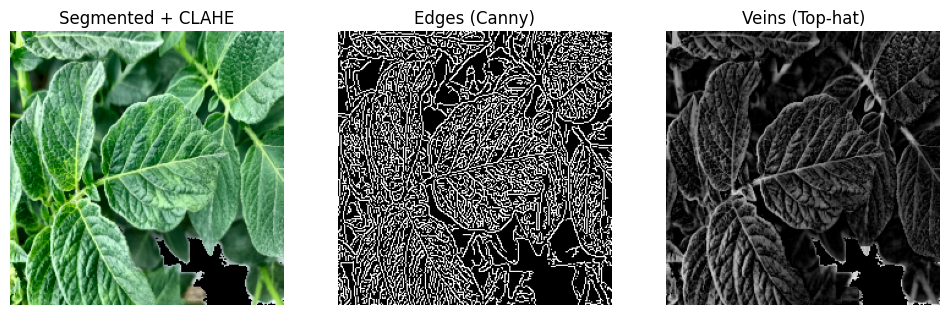

In [15]:
sample_class = random.choice(os.listdir(output_dir))
sample_file = random.choice([f for f in os.listdir(output_dir / sample_class) if '_segmented' in f])

img_path = output_dir / sample_class / sample_file
img = cv2.imread(str(img_path))
edges = cv2.imread(str(output_dir / sample_class / sample_file.replace('_segmented','_edges')),0)
veins = cv2.imread(str(output_dir / sample_class / sample_file.replace('_segmented','_veins')),0)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Segmented + CLAHE')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(edges, cmap='gray')
plt.title('Edges (Canny)')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(veins, cmap='gray')
plt.title('Veins (Top-hat)')
plt.axis('off')
plt.show()
